In [ ]:
import torch
from torch import nn

# Note: Pytorch 1.10.0 or latexr

torch.__version__

#SEt-up device-agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from google.colab import drive # Mount my google drive diretory
drive.mount("/content/gdrive",force_remount=True)
import os # Change directory to CS284 folder in google drive
os.chdir("gdrive/MyDrive/Pruning_Study")

Mounted at /content/gdrive


##Dataset download an preparation

Loads ImageNette Dataset

In [ ]:
!pip install Pillow

In [ ]:
!ls

 CIFAR10
 coco
 Imagenette
 Imagewoof
 ModeL_Pruning_Experiment_07052024.ipynb
 ModeL_Pruning_Experiment_07052024_smallerprune.ipynb
' ModeL_Pruning_Experiment_07072024.ipynb'
 ModeL_Pruning_Experiment_ImageNette07142024.ipynb
' ModeL_Pruning_Experiment_ImageNette07202024.ipynb'
 ModeL_Pruning_Experiment_ImageWoof07202024.ipynb
 models


In [ ]:
#train_csv = 'Imagenette/imagenette2/train.csv'
#test_csv = 'Imagenette/imagenette2/test.csv'

# Root directory containing the images
root_dir = 'Imagewoof/imagewoof2-320'
train_dir='Imagewoof/train_resized'
test_dir='Imagewoof/val_resized'


from torchvision import datasets
import torch
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


trainset=datasets.ImageFolder(root=train_dir,transform=transform_train,#transform for data
                                target_transform=None)# transform for label/target

testset=datasets.ImageFolder(root=test_dir,transform=transform_test,#transform for data
                                target_transform=None)# transform for label/target

trainset,testset

(Dataset ImageFolder
     Number of datapoints: 9025
     Root location: Imagewoof/train_resized
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
            ),
 Dataset ImageFolder
     Number of datapoints: 3629
     Root location: Imagewoof/val_resized
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
            ))

In [ ]:
class_names=trainset.classes
class_dict=trainset.class_to_idx
class_dict

{'n02086240': 0,
 'n02087394': 1,
 'n02088364': 2,
 'n02089973': 3,
 'n02093754': 4,
 'n02096294': 5,
 'n02099601': 6,
 'n02105641': 7,
 'n02111889': 8,
 'n02115641': 9}

In [ ]:
img,label=trainset[0][0],trainset[0][1]
print(f"Image tensor: \n {img}")
print(f"Image Shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image Label: {label}")
print(f"Label datatpe: {type(label)}")

Image tensor: 
 tensor([[[-0.0629, -0.0972, -0.0972,  ..., -0.7479, -0.7650, -0.7822],
         [-0.0972, -0.1657, -0.1657,  ..., -0.7822, -0.7479, -0.7822],
         [-0.1143, -0.1314, -0.2342,  ..., -0.7650, -0.8678, -0.8678],
         ...,
         [ 0.8618,  0.8104,  0.8961,  ..., -0.4226, -0.4397, -0.4397],
         [ 0.7762,  0.8447,  0.8447,  ..., -0.4226, -0.4397, -0.4568],
         [ 0.7591,  0.8276,  0.8789,  ..., -0.4226, -0.4739, -0.4911]],

        [[ 0.0826,  0.0476,  0.0476,  ..., -0.6352, -0.6877, -0.7227],
         [ 0.0476, -0.0224, -0.0224,  ..., -0.6702, -0.6527, -0.7227],
         [ 0.0476,  0.0126, -0.0749,  ..., -0.6527, -0.7577, -0.7752],
         ...,
         [ 1.2731,  1.2381,  1.2906,  ..., -0.2675, -0.2850, -0.2850],
         [ 1.2206,  1.2906,  1.2731,  ..., -0.2500, -0.2850, -0.3025],
         [ 1.2381,  1.2731,  1.3081,  ..., -0.2675, -0.3200, -0.3375]],

        [[ 0.0605,  0.0256,  0.0256,  ..., -0.5321, -0.5495, -0.5844],
         [ 0.0431, -0.0441, -

Original Shapes:torch.Size([3, 224, 224])->C,H,W
Original Shapes:torch.Size([224, 224, 3])->H,W,C


Text(0.5, 1.0, 'n02086240')

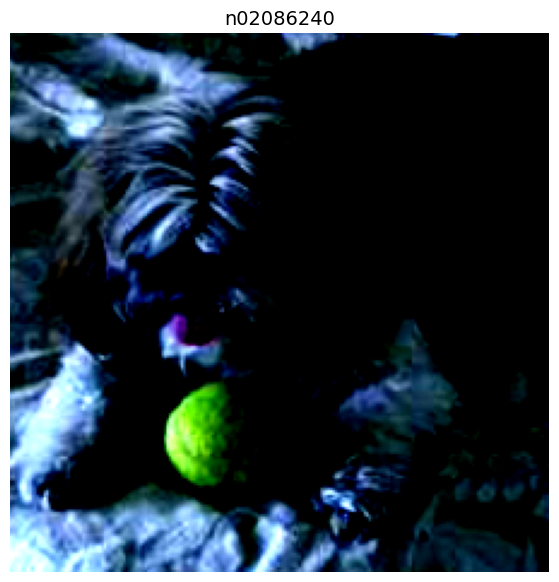

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img_permute=img.permute(1,2,0)
print(f"Original Shapes:{img.shape}->C,H,W")
print(f"Original Shapes:{img_permute.shape}->H,W,C")

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize=14)

In [ ]:
#Batch size and dataloader setting


batch_size = 64
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True,num_workers=4)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False,num_workers=4)

In [ ]:
len(train_dataloader),len(test_dataloader)

(142, 57)

In [ ]:
img,label=next(iter(test_dataloader))

img.shape,label[0]

(torch.Size([64, 3, 224, 224]), tensor(0))

## Full Model

MobileNet V1 implementation is based from here: https://medium.com/@karuneshu21/implement-mobilenet-v1-in-pytorch-fd03a6618321

The implementation is modified to only have 10 classes as we are only using CIFAR-10 Dataset

In [ ]:
import torch
# all nn libraries nn.layer, convs and loss functions

import torch.nn as nn
# Display Image

from IPython.display import Image

# visualisation
!pip install torchview
import torchvision
from torchview import draw_graph

# !pip install transformers
#from transformers import MobileNetV1Config, MobileNetV1Model

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
#Depthwise example

import torch
import torch.nn as nn

# Define a simple depthwise convolutional layer
class DepthwiseConv2d(nn.Module):
    def __init__(self, in_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, padding=padding, groups=in_channels)

    def forward(self, x):
        x = self.depthwise(x)
        return x

# Example usage
# Create a random input tensor
input_tensor = torch.randn(1, 3, 32, 32)  # (batch_size, channels, height, width)

# Define a depthwise convolutional layer
depthwise_conv = DepthwiseConv2d(in_channels=3, kernel_size=3, stride=1, padding=1)

# Apply the depthwise convolution to the input tensor
output_tensor = depthwise_conv(input_tensor)

# Print the shape of the output tensor
print("Output tensor shape:", output_tensor.shape)

Output tensor shape: torch.Size([1, 3, 32, 32])


In [ ]:
import torch
import torch.nn as nn

# Define a simple pointwise convolutional layer
class PointwiseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0):
        super(PointwiseConv2d, self).__init__()
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = self.pointwise(x)
        return x

# Example usage
# Create a random input tensor
input_tensor = torch.randn(1, 3, 32, 32)  # (batch_size, channels, height, width)

# Define a pointwise convolutional layer
pointwise_conv = PointwiseConv2d(in_channels=3, out_channels=64)

# Apply the pointwise convolution to the input tensor
output_tensor = pointwise_conv(input_tensor)

# Print the shape of the output tensor
print("Output tensor shape:", output_tensor.shape)

Output tensor shape: torch.Size([1, 64, 32, 32])


In [ ]:
class DepthWiseSeperable(nn.Module):

    def __init__(self, in_channels , out_channels , stride ):
        """
        DepthWiseSeperable block of MobileNet which performs the following operations:
        (a) depthwise convolution by applying a separate filter for each channel
        (b) pointwise convolutions are applied which combine the filtered result by implementing 1 × 1 convolution

            Note:
                1. groups = in_channels used for depthwise convolution
                2. in_channels and out_channels are same for depthwise convolution
                3. bias = False due to the usage of BatchNorm
                4. To generate same height and width of output feature map as the input feature map, following should be padding for
                    * 1x1 conv : p=0
                    * 3x3 conv : p=1
                    * 5x5 conv : p=2


        Args:
          in_channels (int) : number of input channels
          out_channels (int) : number of output channels
          stride (int) : stride used for depthwise convolution

        Attributes:
            Depthwise seperable convolutional block

        """

        super(DepthWiseSeperable,self).__init__()

        # groups used here
        self.depthwise = nn.Conv2d(in_channels = in_channels , out_channels = in_channels , stride = stride , padding = 1, kernel_size = 3 , groups=in_channels , bias = False)
        self.bn1 = nn.BatchNorm2d(in_channels)

        self.pointwise = nn.Conv2d(in_channels = in_channels , out_channels = out_channels , stride = 1 , padding = 0, kernel_size = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()

    def forward(self,x):

        x = self.depthwise(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.pointwise(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x


def test_DepthWiseSeperable():
    x = torch.randn(1,32,112,112)
    model = DepthWiseSeperable(32,64,2)
    print(model(x).shape)

    return model


#model = test_DepthWiseSeperable()
#architecture = 'DepthWiseSeperable'
#model_graph = draw_graph(model, input_size=(1,32,112,112), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
#model_graph.visual_graph

# output
"""
torch.Size([1, 64, 56, 56])
"""

'\ntorch.Size([1, 64, 56, 56])\n'

In [ ]:
test=img
test.shape

torch.Size([64, 3, 224, 224])

In [ ]:
class MobileNetV1(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 256, 1)
        self.features7 = DepthWiseSeperable(256, 512, 2)
        self.features8 = DepthWiseSeperable(512, 512, 1)
        self.features9 = DepthWiseSeperable(512, 512, 1)
        self.features10 = DepthWiseSeperable(512, 512, 1)
        self.features11 = DepthWiseSeperable(512, 512, 1)
        self.features12 = DepthWiseSeperable(512, 512, 1)
        self.features13 = DepthWiseSeperable(512, 1024, 2)
        self.features14 = DepthWiseSeperable(1024, 1024, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
        x = self.features8(x)
        x = self.features9(x)
        x = self.features10(x)
        x = self.features11(x)
        x = self.features12(x)
        x = self.features13(x)
        x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

In [ ]:
test=img
test.shape
model_big=MobileNetV1()
test_input=test
test_input.shape
test_model=model_big(test_input)
test_model.shape
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  3217226


In [ ]:
# Import time it for training time checking and printing of total time
from timeit import default_timer as timer
def print_train_time(start:float,end:float,device:torch.device=None):
  total_time=end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

def print_test_time(start:float,end:float,device:torch.device=None):
  total_time=end-start
  print(f"Test time on {device}: {total_time:.3f} seconds")
  return total_time

# Function made for accuracy checking
def accuracy_fn(y_target,y_pred):

    correct = (y_target==y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [ ]:
#Training from scratch
from torch.optim.lr_scheduler import CosineAnnealingLR

device="cuda" if torch.cuda.is_available() else "cpu" #device
loss_fn=nn.CrossEntropyLoss()#Loss Function

model_big=MobileNetV1()
optimizer1=torch.optim.Adam(params=model_big.parameters(),lr=0.0005,weight_decay=0.001) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
sigmoid=nn.Sigmoid()

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# Training and Testing Function
def training(model:torch.nn.Module,data_loader:DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer, accuracy_fn,device:torch.device=device):
  train_loss,train_acc=0,0
  model.to(device)
  model.train()

  for batch,(X,y) in enumerate(data_loader):
    X,y=X.float().to(device),y.to(device)

    y_pred=model(X)

    loss=loss_fn(y_pred,y)
    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_loss=train_loss+loss

    train_acc=train_acc+accuracy_fn(y_target=y,y_pred=y_pred_class)
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
  lr_scheduler.step()

  train_loss/=len(data_loader)
  train_acc/=len(data_loader)
  print(f"Train Loss:{train_loss:5f}|Train Acc:{train_acc:5f}%")
  return train_loss,train_acc


def testing(data_loader:DataLoader,model:torch.nn.Module,loss_fn:torch.nn.Module,accuracy_fn,device:torch.device=device):
  test_loss,test_acc=0,0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X,y in data_loader:
      X,y=X.float().to(device),y.to(device)

      test_pred=model(X)

      test_loss=test_loss+loss_fn(test_pred,y)
      y_pred_class=torch.argmax(torch.softmax(test_pred,dim=1),dim=1)
      test_acc=test_acc+accuracy_fn(y_target=y,y_pred=y_pred_class)

    test_loss/=len(data_loader)
    test_acc/=len(data_loader)

    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

    return test_loss,test_acc

In [ ]:

##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=50 #epochs
best_acc=0
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_big_imagewoof.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  print(f"Epoch:{epoch}")
  train_loss,train_acc=training(data_loader=train_dataloader,model=model_big,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_dataloader,model=model_big,loss_fn=loss_fn,accuracy_fn=accuracy_fn)


  if (test_acc>best_acc):
    best_acc=test_acc
    model_big.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model_big.state_dict(),f=model_save_path)
    print(f"New best test acc is {test_acc}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_acc>=best_acc:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model_big_imagewoof.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model_big.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_acc}")
model_big.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:0
Train Loss:2.150651|Train Acc:19.927377%
Test loss: 2.07290 | Test accuracy: 24.59%

New best test acc is 24.588815789473685. Model Saved
Epoch:1
Train Loss:1.954234|Train Acc:27.959947%
Test loss: 1.93097 | Test accuracy: 30.65%

New best test acc is 30.649975633528264. Model Saved
Epoch:2
Train Loss:1.793148|Train Acc:34.066901%
Test loss: 1.78387 | Test accuracy: 37.39%

New best test acc is 37.3879142300195. Model Saved
Epoch:3
Train Loss:1.666215|Train Acc:40.327905%
Test loss: 1.71156 | Test accuracy: 40.04%

New best test acc is 40.04142300194932. Model Saved
Epoch:4
Train Loss:1.551546|Train Acc:44.443222%
Test loss: 1.64690 | Test accuracy: 40.93%

New best test acc is 40.93445419103313. Model Saved
Epoch:5
Train Loss:1.441083|Train Acc:48.118398%
Test loss: 1.56061 | Test accuracy: 46.24%

New best test acc is 46.24269005847953. Model Saved
Epoch:6
Train Loss:1.348591|Train Acc:52.156690%
Test loss: 1.62440 | Test accuracy: 43.02%

Epoch:7
Train Loss:1.266739|Train Ac

2910.8795533879997

In [ ]:
#Loading trained model
def testing(data_loader:DataLoader,model:torch.nn.Module,loss_fn:torch.nn.Module,accuracy_fn,device:torch.device=device):
  test_loss,test_acc=0,0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X,y in data_loader:
      X,y=X.float().to(device),y.to(device)

      test_pred=model(X)

      test_loss=test_loss+loss_fn(test_pred,y)
      y_pred_class=torch.argmax(torch.softmax(test_pred,dim=1),dim=1)
      test_acc=test_acc+accuracy_fn(y_target=y,y_pred=y_pred_class)

    test_loss/=len(data_loader)
    test_acc/=len(data_loader)

    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

    return test_loss,test_acc

# This is when conitnuing training of a previously saved model
from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_big_imagewoof.pth" #modelname
model_save_path=model_path/model_name

#Load testing
sigmoid=nn.Sigmoid()
loss_fn=nn.CrossEntropyLoss()#Loss Function



model_big=MobileNetV1()
model_big.load_state_dict(torch.load(f=model_save_path))
#model_load.state_dict()
optimizer1=torch.optim.Adam(params=model_big.parameters(),lr=0.0005,weight_decay=0.000) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
start_timer=timer()
test_loss,test_acc=testing(data_loader=test_dataloader,model=model_big,loss_fn=loss_fn,accuracy_fn=accuracy_fn)

best_loss=test_loss
best_loss
end_timer=timer()
print_test_time(start=start_timer,end=end_timer,device=device)

Test loss: 1.89349 | Test accuracy: 55.94%

Test time on cuda: 7.805 seconds


7.80469008099999

In [ ]:
import torch
import torch.nn as nn

def get_scaling_factors(network):
    scaling_factors = []
    for module in network.modules():
        if isinstance(module, nn.BatchNorm2d) or isinstance(module, nn.BatchNorm1d):
            scaling_factors.append(module.weight)
    return scaling_factors
scaling_factors=get_scaling_factors(model_big)
scaling_factors[2],max(scaling_factors[2]),min(scaling_factors[2])


(Parameter containing:
 tensor([0.2011, 0.2213, 0.2410, 0.3102, 0.1624, 0.2136, 0.3232, 0.1879, 0.2229,
         0.2195, 0.3504, 0.4146, 0.2895, 0.2943, 0.3094, 0.2101, 0.2877, 0.2991,
         0.1948, 0.2277, 0.3720, 0.3305, 0.2649, 0.2483, 0.2619, 0.2439, 0.2068,
         0.2453, 0.1901, 0.2307, 0.4519, 0.2116, 0.4152, 0.2484, 0.3458, 0.2594,
         0.2771, 0.3230, 0.2472, 0.2459, 0.2004, 0.2484, 0.2304, 0.2375, 0.2548,
         0.2545, 0.4071, 0.2165, 0.1638, 0.2760, 0.2453, 0.2464, 0.2220, 0.2138,
         0.2742, 0.2580, 0.2597, 0.1790, 0.3300, 0.2194, 0.2042, 0.2495, 0.2907,
         0.2036], device='cuda:0', requires_grad=True),
 tensor(0.4519, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.1624, device='cuda:0', grad_fn=<UnbindBackward0>))

## Pruned

The Network is pruned. 5 blocks are removed and are replaced with 2 smaller blocks. Values initialzied from tvalues of the original network

In [ ]:
class MobileNetV1_prunedblock6(nn.Module):

    def __init__(self, num_classes=10):

        super(MobileNetV1_prunedblock6, self).__init__()

        # Initial convolution layer
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )

        # Depthwise separable convolutions
        self.features2 = DepthWiseSeperable(32, 64, 1)
        self.features3 = DepthWiseSeperable(64, 128, 2)
        self.features4 = DepthWiseSeperable(128, 128, 1)
        self.features5 = DepthWiseSeperable(128, 256, 2)

        self.features6 = DepthWiseSeperable(256, 256, 1)
        self.features7 = DepthWiseSeperable(256, 512, 2)
        self.features8 = DepthWiseSeperable(512, 64, 1)
        self.features9 = DepthWiseSeperable(64, 32, 1)
        ##self.features10 = DepthWiseSeperable(512, 512, 1)
        ##self.features11 = DepthWiseSeperable(512, 512, 1)
        ##self.features12 = DepthWiseSeperable(512, 512, 1)
        ##self.features13 = DepthWiseSeperable(512, 1024, 2)
        ##self.features14 = DepthWiseSeperable(1024, 1024, 1)


        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x=  self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = self.features5(x)
        x = self.features6(x)
        x = self.features7(x)
        x = self.features8(x)
        x = self.features9(x)
        #x = self.features10(x)
        #x = self.features11(x)
        #x = self.features12(x)
        #x = self.features13(x)
        #x = self.features14(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create an instance of MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


#model = test_Mobilenet()
#architecture = 'mobilenetv1'
#model_graph = draw_graph(model, input_size=(1,3,64,64), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

In [ ]:
test=img
test.shape
model_small=MobileNetV1_prunedblock6()
test_input=test
test_input.shape
test_model=model_small(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  310794


In [ ]:
!pip install torchinfo
from torchinfo import summary


In [ ]:
#Checking number of parameters of pruned network
summary(model_small, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV1_prunedblock6                 [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 112, 112]         864
│    └─ReLU: 2-2                         [1, 32, 112, 112]         --
│    └─BatchNorm2d: 2-3                  [1, 32, 112, 112]         64
├─DepthWiseSeperable: 1-2                [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         288
│    └─BatchNorm2d: 2-5                  [1, 32, 112, 112]         64
│    └─ReLU: 2-6                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-7                       [1, 64, 112, 112]         2,048
│    └─BatchNorm2d: 2-8                  [1, 64, 112, 112]         128
│    └─ReLU: 2-9                         [1, 64, 112, 112]         --
├─DepthWiseSeperable: 1-3                [1, 128, 56, 56]          --
│    └─Co

In [ ]:
#Checking number of parameters of pruned network
summary(model_big, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV1                              [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 112, 112]         864
│    └─ReLU: 2-2                         [1, 32, 112, 112]         --
│    └─BatchNorm2d: 2-3                  [1, 32, 112, 112]         64
├─DepthWiseSeperable: 1-2                [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         288
│    └─BatchNorm2d: 2-5                  [1, 32, 112, 112]         64
│    └─ReLU: 2-6                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-7                       [1, 64, 112, 112]         2,048
│    └─BatchNorm2d: 2-8                  [1, 64, 112, 112]         128
│    └─ReLU: 2-9                         [1, 64, 112, 112]         --
├─DepthWiseSeperable: 1-3                [1, 128, 56, 56]          --
│    └─Co

Pruned Network only have ~310k parameters while the original network have 3.2M parameters. Step below copies the weights of the original network on the Pruned Network

In [ ]:

#Copying weights
model_small=MobileNetV1_prunedblock6()

features1_parameters = model_big.features1.state_dict()
features2_parameters = model_big.features2.state_dict()
features3_parameters = model_big.features3.state_dict()
features4_parameters = model_big.features4.state_dict()
features5_parameters = model_big.features5.state_dict()
features6_parameters = model_big.features6.state_dict()
features7_parameters = model_big.features7.state_dict()


model_small.features1.load_state_dict(features1_parameters)
model_small.features2.load_state_dict(features2_parameters)
model_small.features3.load_state_dict(features3_parameters)
model_small.features4.load_state_dict(features4_parameters)
model_small.features5.load_state_dict(features5_parameters)
model_small.features6.load_state_dict(features6_parameters)
model_small.features7.load_state_dict(features7_parameters)
for param in model_small.features1.parameters():
    param.requires_grad = True

for param in model_small.features2.parameters():
    param.requires_grad = True


loss_fn=nn.CrossEntropyLoss()#Loss Function


optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.0005,weight_decay=0.001) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)

In [ ]:
#Checking if parameter copy is successful
model_big.features2.state_dict()

OrderedDict([('depthwise.weight',
              tensor([[[[-3.1837e-01,  2.6499e-01,  4.3293e-02],
                        [-2.3375e-01, -2.0953e-02,  1.8485e-01],
                        [-1.5192e-01,  2.2703e-01,  1.3727e-01]]],
              
              
                      [[[-2.7126e-01, -1.7743e-01, -8.6301e-02],
                        [-1.4932e-01, -1.0218e-01, -2.2988e-01],
                        [ 2.4841e-01,  2.8221e-01, -1.1715e-01]]],
              
              
                      [[[-4.6798e-02,  8.4029e-02,  3.9963e-02],
                        [-2.0483e-01,  1.9444e-01,  1.8397e-01],
                        [ 3.0445e-01,  1.6621e-01, -2.5485e-01]]],
              
              
                      [[[ 8.7966e-02, -1.2811e-01,  5.8591e-02],
                        [ 1.3419e-01, -2.9409e-01,  2.2212e-01],
                        [-2.1729e-01, -3.2255e-02,  2.7320e-02]]],
              
              
                      [[[-1.1705e-02,  1.9900e-01, -1.4192

In [ ]:
#Checking if parameter copy is successful
model_small.features2.state_dict()

OrderedDict([('depthwise.weight',
              tensor([[[[-3.1837e-01,  2.6499e-01,  4.3293e-02],
                        [-2.3375e-01, -2.0953e-02,  1.8485e-01],
                        [-1.5192e-01,  2.2703e-01,  1.3727e-01]]],
              
              
                      [[[-2.7126e-01, -1.7743e-01, -8.6301e-02],
                        [-1.4932e-01, -1.0218e-01, -2.2988e-01],
                        [ 2.4841e-01,  2.8221e-01, -1.1715e-01]]],
              
              
                      [[[-4.6798e-02,  8.4029e-02,  3.9963e-02],
                        [-2.0483e-01,  1.9444e-01,  1.8397e-01],
                        [ 3.0445e-01,  1.6621e-01, -2.5485e-01]]],
              
              
                      [[[ 8.7966e-02, -1.2811e-01,  5.8591e-02],
                        [ 1.3419e-01, -2.9409e-01,  2.2212e-01],
                        [-2.1729e-01, -3.2255e-02,  2.7320e-02]]],
              
              
                      [[[-1.1705e-02,  1.9900e-01, -1.4192

In [ ]:
lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=50 #epochs
best_acc=0
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small_imagewoof.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  train_loss,train_acc=training(data_loader=train_dataloader,model=model_small,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
  print(f"Epoch:{epoch}")

  if (test_acc>best_acc):
    best_acc=test_acc
    model_small.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model_small.state_dict(),f=model_save_path)
    print(f"New best test loss is {test_acc}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_acc>=best_acc:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model_small_imagewoof.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model_small.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_acc}")
model_small.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:2.057029|Train Acc:29.467430%
Test loss: 1.90410 | Test accuracy: 33.94%

Epoch:0
New best test loss is 33.93518518518519. Model Saved
Train Loss:1.750249|Train Acc:44.113116%
Test loss: 1.65814 | Test accuracy: 46.65%

Epoch:1
New best test loss is 46.64900097465887. Model Saved
Train Loss:1.535777|Train Acc:50.770246%
Test loss: 1.58583 | Test accuracy: 46.21%

Epoch:2
Train Loss:1.366878|Train Acc:57.119278%
Test loss: 1.47033 | Test accuracy: 49.40%

Epoch:3
New best test loss is 49.397538986354775. Model Saved
Train Loss:1.227377|Train Acc:61.608715%
Test loss: 1.42372 | Test accuracy: 52.71%

Epoch:4
New best test loss is 52.70711500974659. Model Saved
Train Loss:1.100548|Train Acc:66.285211%
Test loss: 1.31402 | Test accuracy: 55.26%

Epoch:5
New best test loss is 55.26072124756335. Model Saved
Train Loss:0.973611|Train Acc:70.675616%
Test loss: 1.23280 | Test accuracy: 57.24%

Epoch:6
New best test loss is 57.23745126705653. Model Saved
Train Loss:0.879721|Train Acc:

1354.6225009720001

In [ ]:
def testing(data_loader:DataLoader,model:torch.nn.Module,loss_fn:torch.nn.Module,accuracy_fn,device:torch.device=device):
  test_loss,test_acc=0,0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X,y in data_loader:
      X,y=X.float().to(device),y.to(device)

      test_pred=model(X)

      test_loss=test_loss+loss_fn(test_pred,y)
      y_pred_class=torch.argmax(torch.softmax(test_pred,dim=1),dim=1)
      test_acc=test_acc+accuracy_fn(y_target=y,y_pred=y_pred_class)

    test_loss/=len(data_loader)
    test_acc/=len(data_loader)

    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

    return test_loss,test_acc

# This is when conitnuing training of a previously saved model
from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small_imagewoof.pth" #modelname
model_save_path=model_path/model_name

#Load testing
sigmoid=nn.Sigmoid()
loss_fn=nn.CrossEntropyLoss()#Loss Function



model_small=MobileNetV1_prunedblock6()
model_small.load_state_dict(torch.load(f=model_save_path))
#model_load.state_dict()
optimizer1=torch.optim.Adam(params=model_small.parameters(),lr=0.001,weight_decay=0.000) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
start_timer=timer()
test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
best_loss=test_loss
best_loss
end_timer=timer()
print_test_time(start=start_timer,end=end_timer,device=device)

Test loss: 1.22416 | Test accuracy: 63.62%

Test time on cuda: 7.941 seconds


7.940785500999482

##Train small network from Random initialization

Trained the pruned network without copying initialization from the original network. The pruned network is trained with random values initialized.

In [ ]:
test=img
test.shape
model_small_random=MobileNetV1_prunedblock6()
test_input=test
test_input.shape
test_model=model_small_random(test_input)
test_model.shape

total_params = sum(p.numel() for p in model_small_random.parameters())
print("Total number of parameters: ", total_params)

loss_fn=nn.CrossEntropyLoss()#Loss Function


optimizer1=torch.optim.Adam(params=model_small_random.parameters(),lr=0.0005,weight_decay=0.001) #Optimizer


lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)

Total number of parameters:  310794


In [ ]:
summary(model_small_random, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV1_prunedblock6                 [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 112, 112]         864
│    └─ReLU: 2-2                         [1, 32, 112, 112]         --
│    └─BatchNorm2d: 2-3                  [1, 32, 112, 112]         64
├─DepthWiseSeperable: 1-2                [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         288
│    └─BatchNorm2d: 2-5                  [1, 32, 112, 112]         64
│    └─ReLU: 2-6                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-7                       [1, 64, 112, 112]         2,048
│    └─BatchNorm2d: 2-8                  [1, 64, 112, 112]         128
│    └─ReLU: 2-9                         [1, 64, 112, 112]         --
├─DepthWiseSeperable: 1-3                [1, 128, 56, 56]          --
│    └─Co

In [ ]:
lr_scheduler = CosineAnnealingLR(optimizer1, T_max=500)
##Training and Testing Loop


#Training Loop

from tqdm.auto import tqdm
import torch

train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

epochs=50 #epochs
best_acc=0
patience=70
max_patience_after_revert = 30
current_patience=0

from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="best_model_small_random_imagewoof.pth" #modelname
model_save_path=model_path/model_name



# Create model save


reverted=False
start_timer=timer()
for epoch in tqdm(range(epochs)):
  train_loss,train_acc=training(data_loader=train_dataloader,model=model_small_random,loss_fn=loss_fn,optimizer=optimizer1,accuracy_fn=accuracy_fn)
  test_loss,test_acc=testing(data_loader=test_dataloader,model=model_small_random,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
  print(f"Epoch:{epoch}")

  if (test_acc>best_acc):
    best_acc=test_acc
    model_small.state_dict()
    best_model_state_dict=model.state_dict()
    torch.save(model_small.state_dict(),f=model_save_path)
    print(f"New best test loss is {test_acc}. Model Saved")
    current_patience=0 #reset patience
    patience_after_revert=0
    reverted=False
  else:
    current_patience+=1

    if current_patience>=patience and not reverted:
      print(f"No improvement for{patience} epochs. Reverting to the best model")
      model.load_state_dict(best_model_state_dict)
      patience_after_revert=0
      reverted=True

  if reverted:
    patience_after_revert+=1
    if patience_after_revert>=max_patience_after_revert:
      print(f"Continue for {max_patience_after_revert} epochs after revert")

      if test_acc>=best_acc:
       print("Test loss still not improving reverting to best model")
       model.load_state_dict(best_model_state_dict)
      patience_after_revert=0


from pathlib import Path
model_path=Path("models")
model_path.mkdir(parents=True,exist_ok=True)
model_name="last_model_small_random_imagewoof.pth" #modelname
model_save_path=model_path/model_name
# Create model save


torch.save(model_small.state_dict(),f=model_save_path)
print(f"Last model is saved with test loss:{test_acc}")
model_small.state_dict()

end_timer=timer()
print_train_time(start=start_timer,end=end_timer,device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:2.180033|Train Acc:19.817342%
Test loss: 2.13264 | Test accuracy: 19.78%

Epoch:0
New best test loss is 19.783138401559455. Model Saved
Train Loss:1.985454|Train Acc:30.468750%
Test loss: 1.88762 | Test accuracy: 31.74%

Epoch:1
New best test loss is 31.736720272904485. Model Saved
Train Loss:1.802432|Train Acc:37.929137%
Test loss: 1.78222 | Test accuracy: 36.92%

Epoch:2
New best test loss is 36.92068713450292. Model Saved
Train Loss:1.633425|Train Acc:44.322183%
Test loss: 1.92478 | Test accuracy: 30.70%

Epoch:3
Train Loss:1.491709|Train Acc:50.033011%
Test loss: 1.50847 | Test accuracy: 47.69%

Epoch:4
New best test loss is 47.69066764132554. Model Saved
Train Loss:1.364854|Train Acc:53.741197%
Test loss: 1.45264 | Test accuracy: 48.91%

Epoch:5
New best test loss is 48.91020955165692. Model Saved
Train Loss:1.246187|Train Acc:58.956866%
Test loss: 1.38215 | Test accuracy: 51.65%

Epoch:6
New best test loss is 51.64717348927875. Model Saved
Train Loss:1.149294|Train Acc

1354.101847772